In [1]:
# Cell 1
import os
import cv2
import multiprocessing
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Cell 2
def extract_frames(video_path, output_folder):
    video_capture = cv2.VideoCapture(video_path)
    success, image = video_capture.read()
    count = 0
    while success:
        frame_path = os.path.join(output_folder, f"frame_{count}.jpg")
        cv2.imwrite(frame_path, image)  # save frame as JPEG file
        success, image = video_capture.read()
        count += 1
    video_capture.release()

def process_videos(videos, output_path):
    for video_file in videos:
        video_path = os.path.join(video_file[0], video_file[1])
        output_folder = os.path.join(output_path, video_file[2], video_file[1].split('.')[0])
        os.makedirs(output_folder, exist_ok=True)
        extract_frames(video_path, output_folder)

In [5]:
if __name__ == "__main__":
    real_videos_path = "Dataset/Real"
    fake_videos_path = "Dataset/Fake"
    output_path = "frames"

    real_videos = [(real_videos_path, file, "Real") for file in os.listdir(real_videos_path)]
    fake_videos = [(fake_videos_path, file, "Fake") for file in os.listdir(fake_videos_path)]
    all_videos = real_videos + fake_videos

    num_processes = multiprocessing.cpu_count()  # Number of CPU cores
    chunk_size = len(all_videos) // num_processes
    chunks = [all_videos[i:i+chunk_size] for i in range(0, len(all_videos), chunk_size)]

    processes = []
    for chunk in chunks:
        p = multiprocessing.Process(target=process_videos, args=(chunk, output_path))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

    for video_file in os.listdir(real_videos_path):
        video_path = os.path.join(real_videos_path, video_file)
        output_folder = os.path.join(output_path, "Real", video_file.split('.')[0])
        os.makedirs(output_folder, exist_ok=True)
        extract_frames(video_path, output_folder)

    for video_file in os.listdir(fake_videos_path):
        video_path = os.path.join(fake_videos_path, video_file)
        output_folder = os.path.join(output_path, "Fake", video_file.split('.')[0])
        os.makedirs(output_folder, exist_ok=True)
        extract_frames(video_path, output_folder)

In [4]:
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
output_path = "frames"
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

batch_size = 64

train_ds = train_datagen.flow_from_directory(directory=output_path, 
                                             subset="training",
                                             target_size=(128, 128),
                                             color_mode="rgb",
                                             batch_size=batch_size,
                                             class_mode="binary",
                                             shuffle=True,
                                             seed=42)

valid_ds = valid_datagen.flow_from_directory(directory=output_path,
                                             subset="validation",
                                             target_size=(128, 128),
                                             color_mode="rgb",
                                             batch_size=batch_size,
                                             class_mode="binary",
                                             shuffle=True,
                                             seed=42)

Found 352 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


In [6]:
# Cell 6
input_shape = (128, 128, 3)
model = create_model(input_shape)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='CNN_model.h5',
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min')

Epoch 1/100


6/6 [==============================] - 6s 740ms/step - loss: 0.5223 - accuracy: 0.7841 - val_loss: 0.3834 - val_accuracy: 0.8456
Epoch 2/100


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 4s 590ms/step - loss: 0.4313 - accuracy: 0.8438 - val_loss: 0.3794 - val_accuracy: 0.8456
Epoch 3/100
6/6 [==============================] - 4s 586ms/step - loss: 0.4351 - accuracy: 0.8438 - val_loss: 0.3779 - val_accuracy: 0.8456
Epoch 4/100
6/6 [==============================] - 4s 584ms/step - loss: 0.4179 - accuracy: 0.8438 - val_loss: 0.3425 - val_accuracy: 0.8456
Epoch 5/100
6/6 [==============================] - 3s 561ms/step - loss: 0.3858 - accuracy: 0.8438 - val_loss: 0.3251 - val_accuracy: 0.8456
Epoch 6/100
6/6 [==============================] - 3s 546ms/step - loss: 0.4033 - accuracy: 0.8438 - val_loss: 0.3498 - val_accuracy: 0.8456
Epoch 7/100
6/6 [==============================] - 3s 604ms/step - loss: 0.3791 - accuracy: 0.8438 - val_loss: 0.3182 - val_accuracy: 0.8456
Epoch 8/100
6/6 [==============================] - 4s 652ms/step - loss: 0.3642 - accuracy: 0.8438 - val_loss: 0.2913 - val_accuracy: 0.8591
Epoch 9/100
6/6 [========

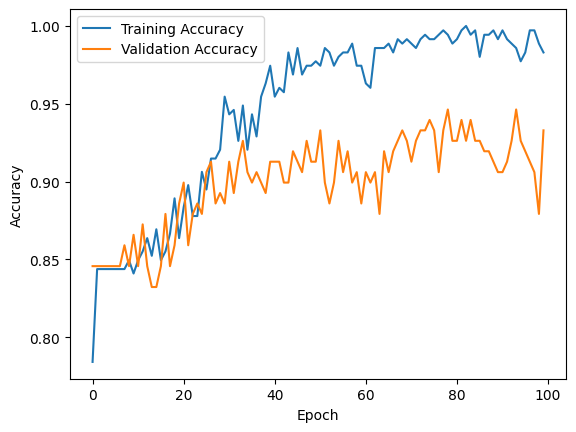

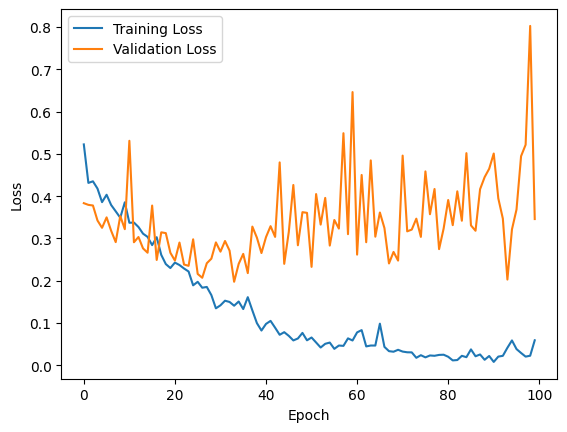

In [7]:
history = model.fit(x=train_ds,
                    validation_data=valid_ds,
                    epochs=100,
                    callbacks=[checkpoint_callback])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Cell 8
model.save('CNN_model.h5')

In [6]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('CNN_model.h5')  # Replace with the path to your trained model

# Function to extract frames from the input video
def extract_frames(video_path):
    frames = []
    video_capture = cv2.VideoCapture(video_path)
    success, image = video_capture.read()
    while success:
        frames.append(image)
        success, image = video_capture.read()
    video_capture.release()
    return frames

# Function to preprocess frames for model prediction
def preprocess_frames(frames):
    processed_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (128, 128))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        processed_frames.append(normalized_frame)
    return np.array(processed_frames)

# Function to predict whether the video is real or fake
def predict_video(video_path):
    frames = extract_frames(video_path)
    processed_frames = preprocess_frames(frames)
    predictions = model.predict(processed_frames)
    mean_prediction = np.mean(predictions)
    print(mean_prediction)
    if abs(mean_prediction) < 1e-6:  # You can adjust the threshold as needed
        return "Real"
    else:
        return "Fake"

# Main function to get input from the user and make predictions
def main():
    video_path = input("Enter the path to the video file: ")
    if not os.path.isfile(video_path):
        print("Error: Invalid file path.")
        return
    result = predict_video(video_path)
    print(f"The video is predicted to be: {result}")

if __name__ == "__main__":
    main()

30/30 [==============================] - 2s 73ms/step
4.894271e-22
The video is predicted to be: Real


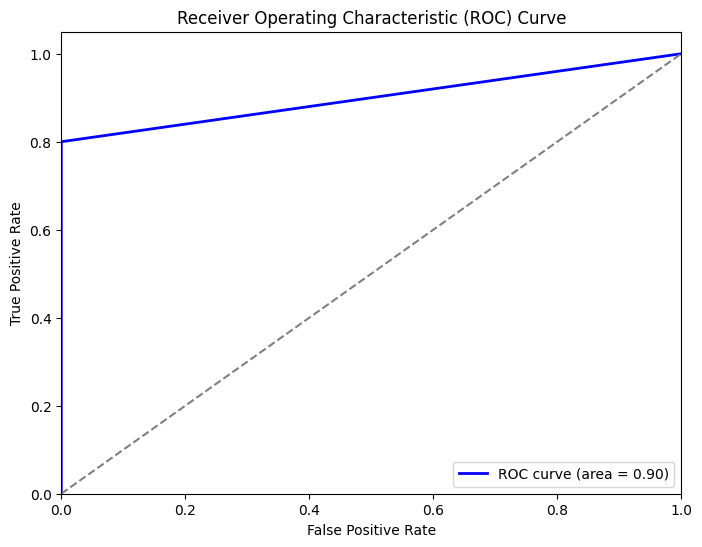

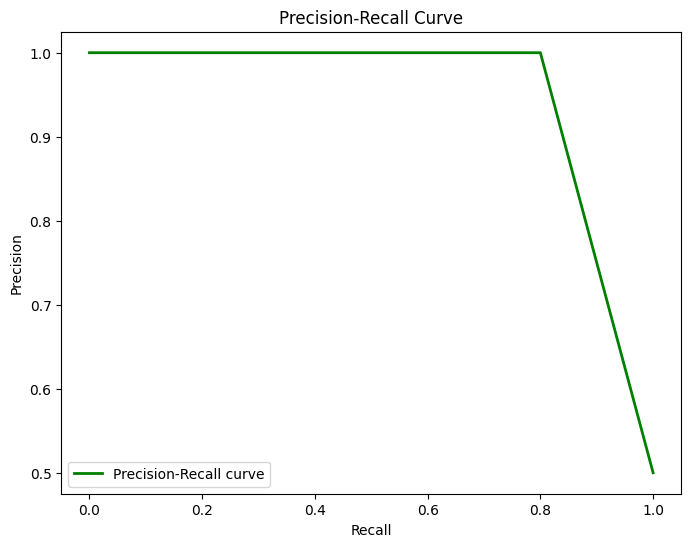

Accuracy: 0.9
Precision: [0.5 1.  1. ]
Recall: [1.  0.8 0. ]
F1 Score: 0.8888888888888888
Confusion Matrix:
[[5 0]
 [1 4]]


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate model performance
def evaluate_performance(y_true, y_pred):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics and confusion matrix
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

# Example usage
# Replace y_true and y_pred with actual and predicted labels
y_true = np.array([0, 1, 0, 1, 1, 0, 1, 0, 0, 1])
y_pred = np.array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0])  # Example predicted labels
evaluate_performance(y_true, y_pred)
